# Fourth Approach: Dimensionality reduction using PCA and re-sampling with SMOTE

In this fouth approach, we will combine the approaches used in the second and third approach. We will preprocess the data by applying **Principal Component Analysis (PCA)** to reduce the dimensionality of the dataset, followed by **Synthetic Minority Over-sampling Technique (SMOTE)** to address class imbalance. First, we will load the data and apply PCA to all features to determine the optimal number of components, which will be selected based on the explained variance ratio. This allows us to retain as much of the data's variance as possible while reducing the dimensionality.

After the PCA transformation, we will apply SMOTE to generate synthetic samples for the minority class, balancing the dataset before training the models. This combination of dimensionality reduction and oversampling is aimed at improving model performance, particularly on imbalanced datasets.

To be able to compare the results with the rest of the approaches, we will use the same configuration of hyperparameters for the models:

- **ANN**:
  - Hidden layers: 1, number of neurons in the hidden layer: $[16, 32, 64]$.
  - Hidden layers: 2, number of neurons in the hidden layers $[(16, 16), (32, 16), (32, 32), (64, 32), (64, 64)]$.
- **Decision Tree**:
  - Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{None}\}$
- **SVM**:
  - Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
  - C $\in \{0.1, 1, 10\}$
- **KNN\***:
  - $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$

After training the models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Naive Bayes**
- **Stacking** (using a logistic regression as the meta-model)


**Index**

- [Data loading](#Data-loading)
- [PCA Transformation](#PCA-Transformation)
- [Individual models](#Individual-models)
  - [ANN](#ANN)
  - [Decision Tree](#Decision-Tree)
  - [Support Vector Machine](#Support-Vector-Machine)
  - [K-Nearest Neighbors](#K-Nearest-Neighbors)
- [Ensemble model](#Ensemble-model)
  - [Majority voting](#Majority-voting)
  - [Weighted voting](#Weighted-voting)
  - [Naive Bayes](#Naive-Bayes)
  - [Stacking](#Stacking)


## Data loading

In [1]:
using DataFrames
using CSV
using Serialization

In [2]:
# Load custom functions from provided files
include("preprocessing.jl")
include("metrics.jl")
include("training.jl")
include("plotting.jl")

┌ Info: Running `conda install -y -c anaconda conda` in root environment
└ @ Conda /home/markel/.julia/packages/Conda/zReqD/src/Conda.jl:181


Channels:
 - anaconda
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/markel/.julia/conda/3/x86_64

  added / updated specs:
    - conda


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2024.8.30~ --> anaconda/linux-64::certifi-2024.8.30-py312h06a4308_0 



Preparing transaction: done
Verifying transaction: done
Executing transaction: done


┌ Info: Running `conda install -y -c conda-forge 'libstdcxx-ng>=3.4,<13.0'` in root environment
└ @ Conda /home/markel/.julia/packages/Conda/zReqD/src/Conda.jl:181


Channels:
 - conda-forge
 - defaults
 - anaconda
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/markel/.julia/conda/3/x86_64

  added / updated specs:
    - libstdcxx-ng[version='>=3.4,<13.0']


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            anaconda/linux-64::certifi-2024.8.30-~ --> conda-forge/noarch::certifi-2024.8.30-pyhd8ed1ab_0 



Preparing transaction: done
Verifying transaction: done
Executing transaction: done


generateComparisonTable (generic function with 2 methods)

In [3]:
# Set the random seed for reproducibility
Random.seed!(42)

# Load the dataset
dataset_path = "dataset.csv"
data = CSV.read(dataset_path, DataFrame)
data[1:5, :]

5×35 DataFrame
 Row │ Marital status  Application mode  Application order  Course  Daytime/ev ⋯
     │ Int64           Int64             Int64              Int64   Int64      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │              1                 8                  5       2             ⋯
   2 │              1                 6                  1      11
   3 │              1                 1                  5       5
   4 │              1                 8                  2      15
   5 │              2                12                  1       3             ⋯
                                                              31 columns omitted

In [4]:
# Separate features and target
target_column = :Target
inputs = select(data, Not(target_column))
targets = data[!, target_column];

In [5]:
inputs = Float32.(Matrix(inputs))

# Define the categories and their mapping
label_mapping = Dict("Dropout" => 0, "Graduate" => 1, "Enrolled" => 2)

# Encode the targets
targets_label_encoded = [label_mapping[label] for label in targets]

println("Encoded targets: ", targets_label_encoded[1:5])

# To decode later, create a reverse mapping
reverse_mapping = Dict(v => k for (k, v) in label_mapping)
decoded_targets = [reverse_mapping[code] for code in targets_label_encoded]

println("Decoded targets: ", decoded_targets[1:5])

Encoded targets: [0, 1, 0, 1, 1]
Decoded targets: ["Dropout", "Graduate", "Dropout", "Graduate", "Graduate"]


## PCA transformation

In [6]:
inputs = Float32.(Matrix(inputs))

# Define the number of folds for cross-validation and obtain the indices
Random.seed!(42)
k = 5
N = size(inputs, 1)
fold_indices = crossValidation(targets, k)
metrics_to_save = [:accuracy, :precision, :recall, :f1_score];

In [7]:
target_column = :Target
println("\nClass Distribution:")
println(combine(groupby(data, target_column), nrow => :Count))


Class Distribution:
3×2 DataFrame
 Row │ Target    Count 
     │ String15  Int64 
─────┼─────────────────
   1 │ Dropout    1421
   2 │ Graduate   2209
   3 │ Enrolled    794


## SMOTE Experiments


In [8]:
smote_percentages = [
  Dict("Enrolled" => 200),
  Dict("Enrolled" => 300),
  Dict("Enrolled" => 200, "Dropout" => 200),
  Dict("Enrolled" => 300, "Dropout" => 200),
  Dict("Enrolled" => 200, "Graduate" => 50)
]
k = 5

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for (i, smote_percentage) in enumerate(smote_percentages)
      println("\nSmote percentages: ", smote_percentage)
      balanced_inputs, balanced_targets = smote(inputs, targets, smote_percentage, k)
      println("Number of instances: ", size(balanced_targets)[1])
      println("Elements of class Dropout: ", sum(balanced_targets .== "Dropout"))
      println("Elements of class Graduate: ", sum(balanced_targets .== "Graduate"))
      println("Elements of class Enrolled: ", sum(balanced_targets .== "Enrolled"))
    end
  end
end


Smote percentages: Dict("Enrolled" => 200)
Number of instances: 5218
Elements of class Dropout: 1421
Elements of class Graduate: 2209
Elements of class Enrolled: 1588

Smote percentages: Dict("Enrolled" => 300)
Number of instances: 6012
Elements of class Dropout: 1421
Elements of class Graduate: 2209
Elements of class Enrolled: 2382

Smote percentages: Dict("Enrolled" => 200, "Dropout" => 200)
Number of instances: 6639
Elements of class Dropout: 2842
Elements of class Graduate: 2209
Elements of class Enrolled: 1588

Smote percentages: Dict("Enrolled" => 300, "Dropout" => 200)
Number of instances: 7433
Elements of class Dropout: 2842
Elements of class Graduate: 2209
Elements of class Enrolled: 2382

Smote percentages: Dict("Enrolled" => 200, "Graduate" => 50)
Number of instances: 4113
Elements of class Dropout: 1421
Elements of class Graduate: 1104
Elements of class Enrolled: 1588


In [8]:
# Best configurations
topology = [32, 16]
topology_scikit_ann = [32]
max_depth = 5
n_neighbors = 11
kernel = "rbf"
C = 1

# ANN
hyperparameters_ann = Dict(
  "topology" => topology,
  "learningRate" => 0.01,
  "maxEpochs" => 100,
  "repetitionsTraining" => 10,
  "validationRatio" => 0.15,
  "maxEpochsVal" => 10,
  "minLoss" => 0.0001
)

# scikitANN
hyperparameters_scikit_ann = Dict(
  :hidden_layer_sizes => topology_scikit_ann,
  :learning_rate_init => 0.01,
  :max_iter => 100,
  :early_stopping => true,
  :tol => 0,
  :validation_fraction => 0.15,
  :n_iter_no_change => 10,
  :epsilon => 0.0001,
  :repetitionsTraining => 10
)

# DT
hyperparameters_dt = Dict(
  :max_depth => max_depth,
  :criterion => "gini",
  :min_samples_split => 2,
)

# SVM
hyperparameters_svm = Dict(
  :kernel => kernel,
  :C => C,
  :gamma => "auto",
  :probability => true,
)

# KNN
hyperparameters_knn = Dict(
  :n_neighbors => n_neighbors,
  :weights => "uniform",
  :metric => "euclidean",
)

# Define the hyperparameters for smote
k = 5
smote_percentages = [
  Dict("Enrolled" => 200),
  Dict("Enrolled" => 300),
  Dict("Enrolled" => 200, "Dropout" => 200),
  Dict("Enrolled" => 300, "Dropout" => 200),
  Dict("Enrolled" => 200, "Graduate" => 50),
  Dict{String,Int}()
];

In [9]:
Random.seed!(42)

general_results_ann = []
class_results_ann = []
general_results_scikit_ann = []
class_results_scikit_ann = []
general_results_dt = []
class_results_dt = []
general_results_svm = []
class_results_svm = []
general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for smote_percentage in smote_percentages
      println("\nSmote percentage: ", smote_percentage)

      # ANN
      println("ANN")
      gr, cr = modelCrossValidation(
        :ANN,
        hyperparameters_ann,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applyPCA=true,
        pcaComponents=0.95,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_ann, gr)
      push!(class_results_ann, cr)

      # Scikit ANN
      println("scikitANN")
      gr, cr = modelCrossValidation(
        :scikit_ANN,
        hyperparameters_scikit_ann,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applyPCA=true,
        pcaComponents=0.95,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )

      push!(general_results_scikit_ann, gr)
      push!(class_results_scikit_ann, cr)

      # DT
      println("DT")
      gr, cr = modelCrossValidation(
        :DT,
        hyperparameters_dt,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applyPCA=true,
        pcaComponents=0.95,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_dt, gr)
      push!(class_results_dt, cr)

      # SVM
      println("SVM")
      gr, cr = modelCrossValidation(
        :SVC,
        hyperparameters_svm,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applyPCA=true,
        pcaComponents=0.95,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_svm, gr)
      push!(class_results_svm, cr)

      # KNN
      println("KNN")
      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters_knn,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applyPCA=true,
        pcaComponents=0.95,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end


Smote percentage: Dict("Enrolled" => 200)
ANN


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(24 => 32, σ)
│   summary(x) = 24×3548 adjoint(::Matrix{Float64}) with eltype Float64
└ @ Flux /home/markel/.julia/packages/Flux/vwk6M/src/layers/stateless.jl:59


Mean accuracy: 0.51288 ± 0.02625
	Class 1: 0.45334 ± 0.04798
	Class 2: 0.46123 ± 0.0276
	Class 3: 0.76305 ± 0.05006
Mean precision: 0.23474 ± 0.03397
	Class 1: 0.24193 ± 0.06489
	Class 2: 0.2641 ± 0.03317
	Class 3: 0.14019 ± 0.11065
Mean recall: 0.33881 ± 0.03983
	Class 1: 0.4452 ± 0.08685
	Class 2: 0.35579 ± 0.10899
	Class 3: 0.1013 ± 0.08634
Mean f1_score: 0.22118 ± 0.0243
	Class 1: 0.25055 ± 0.04544
	Class 2: 0.26046 ± 0.07333
	Class 3: 0.0594 ± 0.03699
scikitANN
Mean accuracy: 0.82669 ± 0.00865
	Class 1: 0.83189 ± 0.01636
	Class 2: 0.8301 ± 0.0197
	Class 3: 0.81705 ± 0.00971
Mean precision: 0.70897 ± 0.02207
	Class 1: 0.75553 ± 0.03011
	Class 2: 0.72587 ± 0.04878
	Class 3: 0.5036 ± 0.0411
Mean recall: 0.73952 ± 0.01357
	Class 1: 0.84005 ± 0.07918
	Class 2: 0.76276 ± 0.09853
	Class 3: 0.28131 ± 0.06486
Mean f1_score: 0.71115 ± 0.01718
	Class 1: 0.7921 ± 0.04989
	Class 2: 0.73653 ± 0.07146
	Class 3: 0.34521 ± 0.04803
DT
Mean accuracy: 0.7743 ± 0.02742
	Class 1: 0.75545 ± 0.05874
	Cla

### Save the results and analysis

In [10]:
# Save the results
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "4_smote_results.jl"

parameters = Dict("Enrolled" => [200, 300, 200, 300, 200, 100], "Dropout" => [100, 100, 200, 200, 100, 100], "Graduate" => [100, 100, 100, 100, 50, 100])

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => parameters,
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :scikit_ANN => Dict(
    "num_trained_models" => length(general_results_scikit_ann),
    "parameters" => parameters,
    "general_results" => general_results_scikit_ann,
    "class_results" => class_results_scikit_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => parameters,
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => parameters,
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => parameters,
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

In [11]:
results_folder = "results/"
filename = results_folder * "4_smote_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end;

In [13]:
# Generate tables for each algorithm sorted by f1 score
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, rev=true, output_dir="./tables/Approach4/smote/")


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────────────────────────────┬──────────┬───────────┬──────────┬──────────┐
│                              Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────────────────────────────┼──────────┼───────────┼──────────┼──────────┤
│ Enrolled: 100, Graduate: 100, Dropout: 100 │ 0.797803 │  0.709361 │ 0.702825 │ 0.694731 │
│ Enrolled: 300, Graduate: 100, Dropout: 100 │ 0.782833 │  0.693434 │ 0.679096 │ 0.676134 │
│ Enrolled: 200, Graduate: 100, Dropout: 100 │ 0.791587 │  0.680377 │ 0.703955 │ 0.672764 │
│ Enrolled: 200, Graduate: 100, Dropout: 200 │ 0.769802 │  0.678528 │ 0.668927 │ 0.650682 │
│ Enrolled: 300, Graduate: 100, Dropout: 200 │ 0.769894 │  0.673491 │ 0.665537 │  0.64814 │
│  Enrolled: 200, Graduate: 50, Dropout: 100 │ 0.681453 │  0.611976 │ 0.528814 │ 0.538908 │
└────────────────────────────────────────────┴──────────┴───────────┴──────────┴──────────┘
Result

## ANN

We are going to start with our implementation for Artificial Neural Networks. To augment the robustness of the model, we will train each architecture 10 times with each fold of the cross-validation.

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons


In [9]:
# Set the random seed for reproducibility
Random.seed!(42)

topologies = [ [64, 32], [16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 64]]

smote_percentage = Dict("Enrolled" => 300)

general_results_ann = []
class_results_ann = []

for topology in topologies
  hyperparameters = Dict(
    "topology" => topology,
    "learningRate" => 0.01,
    "maxEpochs" => 100,
    "repetitionsTraining" => 10,
    "validationRatio" => 0.15,
    "maxEpochsVal" => 10,
    "minLoss" => 0.0001
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    applyPCA=true,
    pcaComponents=0.95,
    applySmote=true,
    smotePercentages=smote_percentage,
    smoteNeighbors=k,
    verbose=false
  )

  push!(general_results_ann, gr)
  push!(class_results_ann, cr)
end

Training ANN with topology: [64, 32]


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(24 => 64, σ)
│   summary(x) = 24×4089 adjoint(::Matrix{Float64}) with eltype Float64
└ @ Flux /home/markel/.julia/packages/Flux/vwk6M/src/layers/stateless.jl:59


Mean accuracy: 0.47982 ± 0.01607
	Class 1: 0.42887 ± 0.0416
	Class 2: 0.45391 ± 0.02002
	Class 3: 0.64298 ± 0.07783
Mean precision: 0.14197 ± 0.01305
	Class 1: 0.18566 ± 0.03244
	Class 2: 0.11347 ± 0.03282
	Class 3: 0.14307 ± 0.01622
Mean recall: 0.26288 ± 0.02993
	Class 1: 0.45138 ± 0.08549
	Class 2: 0.11958 ± 0.08578
	Class 3: 0.32432 ± 0.11512
Mean f1_score: 0.15646 ± 0.025
	Class 1: 0.25357 ± 0.04865
	Class 2: 0.09377 ± 0.05291
	Class 3: 0.15708 ± 0.01812
Training ANN with topology: [16]
Mean accuracy: 0.62474 ± 0.15965
	Class 1: 0.62508 ± 0.18167
	Class 2: 0.59309 ± 0.18196
	Class 3: 0.7121 ± 0.07368
Mean precision: 0.42868 ± 0.222
	Class 1: 0.42294 ± 0.25372
	Class 2: 0.49795 ± 0.24668
	Class 3: 0.24627 ± 0.09799
Mean recall: 0.46514 ± 0.21263
	Class 1: 0.45999 ± 0.20878
	Class 2: 0.53805 ± 0.31049
	Class 3: 0.27173 ± 0.06576
Mean f1_score: 0.41526 ± 0.23912
	Class 1: 0.405 ± 0.25464
	Class 2: 0.48967 ± 0.29602
	Class 3: 0.22671 ± 0.07324
Training ANN with topology: [32]
Mean acc

## ScikitLearn ANN

We will use the MLPClassifier from ScikitLearn to train the ANN models. The hyperparameters used in the models are the same as in the previous ANN implementation:

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons

In [10]:
# Set the random seed for reproducibility
Random.seed!(42)

topologies = [[16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 32], [64, 64]]

general_results_scikit_ann = []
class_results_scikit_ann = []

for topology in topologies
  hyperparameters = Dict(
    :hidden_layer_sizes => topology,
    :learning_rate_init => 0.01,
    :max_iter => 100,
    :early_stopping => true,
    :tol => 0,
    :validation_fraction => 0.15,
    :n_iter_no_change => 10,
    :epsilon => 0.0001,
    :repetitionsTraining => 10
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :scikit_ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    applyPCA=true,
    pcaComponents=0.95,
    applySmote=true,
    smotePercentages=smote_percentage,
    smoteNeighbors=k,
    verbose=false
  )

  push!(general_results_scikit_ann, gr)
  push!(class_results_scikit_ann, cr)
end

Training ANN with topology: [16]
Mean accuracy: 0.82754 ± 0.00748
	Class 1: 0.83375 ± 0.01745
	Class 2: 0.83267 ± 0.0174
	Class 3: 0.81244 ± 0.01212
Mean precision: 0.71742 ± 0.01686
	Class 1: 0.7752 ± 0.02603
	Class 2: 0.75275 ± 0.0256
	Class 3: 0.47604 ± 0.06344
Mean recall: 0.73943 ± 0.01228
	Class 1: 0.84469 ± 0.06866
	Class 2: 0.77418 ± 0.08561
	Class 3: 0.30438 ± 0.04622
Mean f1_score: 0.72133 ± 0.01363
	Class 1: 0.80591 ± 0.03518
	Class 2: 0.76061 ± 0.05058
	Class 3: 0.36712 ± 0.05198
Training ANN with topology: [32]
Mean accuracy: 0.82692 ± 0.00772
	Class 1: 0.83228 ± 0.01499
	Class 2: 0.8303 ± 0.01699
	Class 3: 0.81497 ± 0.00941
Mean precision: 0.7142 ± 0.0175
	Class 1: 0.76685 ± 0.02177
	Class 2: 0.74731 ± 0.03005
	Class 3: 0.48097 ± 0.04948
Mean recall: 0.73877 ± 0.01239
	Class 1: 0.84179 ± 0.06548
	Class 2: 0.78344 ± 0.06017
	Class 3: 0.28815 ± 0.0525
Mean f1_score: 0.71836 ± 0.01477
	Class 1: 0.8005 ± 0.03701
	Class 2: 0.76192 ± 0.03503
	Class 3: 0.35587 ± 0.05342
Training

### Decision Tree

The Decision Tree model will be trained with the following hyperparameters:

- Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{nothing}\}$


In [11]:
max_depths = [3, 5, 10, 15, 20, nothing]

general_results_dt = []
class_results_dt = []

for max_depth in max_depths
  hyperparameters = Dict(
    :max_depth => max_depth,
    :criterion => "gini",
    :min_samples_split => 2,
  )

  println("Training DT model with max_depth: ", max_depth)

  gr, ct = modelCrossValidation(
    :DT,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    applyPCA=true,
    pcaComponents=0.95,
    applySmote=true,
    smotePercentages=smote_percentage,
    smoteNeighbors=k,
    verbose=false
  )

  push!(general_results_dt, gr)
  push!(class_results_dt, ct)
end

Training DT model with max_depth: 3
Mean accuracy: 0.7517 ± 0.01617
	Class 1: 0.72357 ± 0.04277
	Class 2: 0.78278 ± 0.03885
	Class 3: 0.78799 ± 0.0261
Mean precision: 0.62702 ± 0.01508
	Class 1: 0.66749 ± 0.03316
	Class 2: 0.732 ± 0.05336
	Class 3: 0.33511 ± 0.0616
Mean recall: 0.64717 ± 0.02218
	Class 1: 0.80864 ± 0.13684
	Class 2: 0.63461 ± 0.16354
	Class 3: 0.15619 ± 0.02805
Mean f1_score: 0.61797 ± 0.01959
	Class 1: 0.72479 ± 0.05528
	Class 2: 0.66666 ± 0.06408
	Class 3: 0.20837 ± 0.02073
Training DT model with max_depth: 5
Mean accuracy: 0.77171 ± 0.01499
	Class 1: 0.76222 ± 0.03876
	Class 2: 0.7733 ± 0.03716
	Class 3: 0.78594 ± 0.04185
Mean precision: 0.6715 ± 0.03014
	Class 1: 0.67299 ± 0.1723
	Class 2: 0.64206 ± 0.19996
	Class 3: 0.52004 ± 0.27009
Mean recall: 0.66073 ± 0.02132
	Class 1: 0.66177 ± 0.17801
	Class 2: 0.65599 ± 0.19986
	Class 3: 0.45115 ± 0.16764
Mean f1_score: 0.66039 ± 0.02284
	Class 1: 0.66064 ± 0.1567
	Class 2: 0.64592 ± 0.19288
	Class 3: 0.47787 ± 0.20826
Tra

### Support Vector Machine

The SVM model will be trained with all the possible combinations of the following hyperparameters:

- Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
- C $\in \{0.1, 1, 10\}$


In [12]:
kernel_C = [
  ("linear", 0.1),
  ("linear", 1.0),
  ("linear", 10.0),
  ("poly", 0.1),
  ("poly", 1.0),
  ("poly", 10.0),
  ("rbf", 0.1),
  ("rbf", 1.0),
  ("rbf", 10.0),
  ("sigmoid", 0.1),
  ("sigmoid", 1.0),
  ("sigmoid", 10.0)
]

general_results_svm = []
class_results_svm = []

for (kernel, C) in kernel_C
  hyperparameters = Dict(
    :kernel => kernel,
    :C => C,
    :gamma => "auto",
    :probability => true,
  )

  println("Training SVM model with kernel: ", kernel, " and C: ", C)

  gr, cr = modelCrossValidation(
    :SVC,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    applyPCA=true,
    pcaComponents=0.95,
    applySmote=true,
    smotePercentages=smote_percentage,
    smoteNeighbors=k,
    verbose=false
  )

  push!(general_results_svm, gr)
  push!(class_results_svm, cr)
end

Training SVM model with kernel: linear and C: 0.1
Mean accuracy: 0.82406 ± 0.0069
	Class 1: 0.83476 ± 0.01414
	Class 2: 0.81467 ± 0.02195
	Class 3: 0.81623 ± 0.02129
Mean precision: 0.72168 ± 0.01054
	Class 1: 0.78057 ± 0.01706
	Class 2: 0.6365 ± 0.19143
	Class 3: 0.58736 ± 0.19664
Mean recall: 0.73283 ± 0.00997
	Class 1: 0.78727 ± 0.09262
	Class 2: 0.64578 ± 0.26407
	Class 3: 0.52042 ± 0.23849
Mean f1_score: 0.72458 ± 0.00951
	Class 1: 0.78163 ± 0.04568
	Class 2: 0.63863 ± 0.22658
	Class 3: 0.54963 ± 0.21928
Training SVM model with kernel: linear and C: 1.0
Mean accuracy: 0.82252 ± 0.00867
	Class 1: 0.83543 ± 0.015
	Class 2: 0.8124 ± 0.02216
	Class 3: 0.81374 ± 0.02162
Mean precision: 0.72192 ± 0.01187
	Class 1: 0.78188 ± 0.01878
	Class 2: 0.63905 ± 0.18941
	Class 3: 0.58396 ± 0.19779
Mean recall: 0.73079 ± 0.01256
	Class 1: 0.78822 ± 0.09109
	Class 2: 0.64161 ± 0.25035
	Class 3: 0.52773 ± 0.22534
Mean f1_score: 0.72409 ± 0.01166
	Class 1: 0.78274 ± 0.04442
	Class 2: 0.6382 ± 0.21804


### K-Nearest Neighbors

The KNN model will be trained with the following hyperparameters:

- $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$


In [13]:
n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15]

general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for n in n_neighbors
      hyperparameters = Dict(
        :n_neighbors => n,
        :weights => "uniform",
        :metric => "euclidean",
      )

      println("Training KNN model with n_neighbors: ", n)

      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applyPCA=true,
        pcaComponents=0.95,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )

      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end

Training KNN model with n_neighbors: 1
Mean accuracy: 0.77162 ± 0.01075
	Class 1: 0.78705 ± 0.03084
	Class 2: 0.76494 ± 0.02215
	Class 3: 0.77895 ± 0.03251
Mean precision: 0.6551 ± 0.01694
	Class 1: 0.72747 ± 0.0118
	Class 2: 0.55317 ± 0.22418
	Class 3: 0.51833 ± 0.17009
Mean recall: 0.66547 ± 0.01845
	Class 1: 0.71358 ± 0.07424
	Class 2: 0.57416 ± 0.27618
	Class 3: 0.47159 ± 0.22735
Mean f1_score: 0.65809 ± 0.01706
	Class 1: 0.71907 ± 0.04002
	Class 2: 0.56193 ± 0.24783
	Class 3: 0.49084 ± 0.19922
Training KNN model with n_neighbors: 3
Mean accuracy: 0.77513 ± 0.01131
	Class 1: 0.77871 ± 0.03019
	Class 2: 0.78618 ± 0.02588
	Class 3: 0.76561 ± 0.02317
Mean precision: 0.66468 ± 0.0165
	Class 1: 0.73952 ± 0.0059
	Class 2: 0.72552 ± 0.01501
	Class 3: 0.34804 ± 0.05633
Mean recall: 0.66525 ± 0.01982
	Class 1: 0.72855 ± 0.08809
	Class 2: 0.7081 ± 0.09112
	Class 3: 0.34385 ± 0.04301
Mean f1_score: 0.66343 ± 0.01783
	Class 1: 0.73192 ± 0.04699
	Class 2: 0.7149 ± 0.05191
	Class 3: 0.34576 ± 0.

### Save the results

In order to be able to compare the results of the models without running the training again, we will save the results in a dictionary. The dictionary will have the following structure:

```julia
{
    :model: {
        'num_trained_models': int,
        'parameters': Dict{String, Any},
        'general_results': [
            {
                'accuracy': AbstractVector{Float64},
                'precision': AbstractVector{Float64},
                'recall': AbstractVector{Float64},
                'f1_score': AbstractVector{Float64},
            },
            ... # One element for each trained model
        ],
        'class_results': [
            [
                {
                    'accuracy': AbstractVector{Float64},
                    'precision': AbstractVector{Float64},
                    'recall': AbstractVector{Float64},
                    'f1_score': AbstractVector{Float64},
                },
                ... # One element for each class
            ],
            ... # One element for each trained model
        ]
    }
}
```

The results of all approaches will be avaiable in the `results` dictionary. The filename with the results of individual models of this first approach will be `1_individual_results.jl`.


In [14]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "4_individual_results.jl"

# Separete the kernel and C values of the hyperparameter list for SVM
kernels = [item[1] for item in kernel_C]
C_values = [item[2] for item in kernel_C]

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => Dict(
      "topology" => topologies
    ),
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :scikit_ANN => Dict(
    "num_trained_models" => length(general_results_scikit_ann),
    "parameters" => Dict(
      "hidden_layer_sizes" => topologies
    ),
    "general_results" => general_results_scikit_ann,
    "class_results" => class_results_scikit_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => Dict(
      "max_depth" => max_depths
    ),
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => Dict(
      "kernel" => kernels,
      "C" => C_values
    ),
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => Dict(
      "n_neighbors" => n_neighbors
    ),
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

## Base model plots

In [15]:
results_folder = "results/"
filename = results_folder * "4_individual_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end

model_names, metrics, metric_means, metric_stds, metric_maxes = aggregateMetrics(loaded_obj)

(Any["DT", "KNN", "SVM", "scikit_ANN", "ANN"], [:accuracy, :precision, :recall, :f1_score], Dict{Symbol, Vector{Any}}(:recall => [0.6482206103941501, 0.6711829620422274, 0.706738855254855, 0.7363028608561736, 0.4149270353770683], :f1_score => [0.6369308963360393, 0.6748749259466157, 0.6976265100314826, 0.7135911284779322, 0.3436590276499636], :precision => [0.6361400807727504, 0.6934925393891465, 0.7022674801950503, 0.7105179890785803, 0.35335206182709283], :accuracy => [0.7596705473154352, 0.7818083119527003, 0.8054704378811611, 0.8244497547501948, 0.5906149598028919]), Dict{Symbol, Vector{Any}}(:recall => [0.0088793880109046, 0.0043664489556589975, 0.03599230309771437, 0.002445520671727054, 0.0809850376794253], :f1_score => [0.014707910688610376, 0.009069386375527096, 0.029439227954735057, 0.005029378628518401, 0.10026449286352536], :precision => [0.01818442496771213, 0.02281833699243934, 0.027378690859701557, 0.004615723183467412, 0.10959787084550528], :accuracy => [0.00820902967055

In [16]:
model_names, metrics, metric_means, metric_stds, metric_means_class, metric_stds_class, metric_maxes, metric_maxes_class = aggregateMetrics(loaded_obj, 3)

(Any["DT", "KNN", "SVM", "scikit_ANN", "ANN"], [:accuracy, :precision, :recall, :f1_score], Dict{Symbol, Vector{Any}}(:recall => [0.6482206103941501, 0.6711829620422274, 0.706738855254855, 0.7363028608561736, 0.4149270353770683], :f1_score => [0.6369308963360393, 0.6748749259466157, 0.6976265100314826, 0.7135911284779322, 0.3436590276499636], :precision => [0.6361400807727504, 0.6934925393891465, 0.7022674801950503, 0.7105179890785803, 0.35335206182709283], :accuracy => [0.7596705473154352, 0.7818083119527003, 0.8054704378811611, 0.8244497547501948, 0.5906149598028919]), Dict{Symbol, Vector{Any}}(:recall => [0.0088793880109046, 0.0043664489556589975, 0.03599230309771437, 0.002445520671727054, 0.0809850376794253], :f1_score => [0.014707910688610376, 0.009069386375527096, 0.029439227954735057, 0.005029378628518401, 0.10026449286352536], :precision => [0.01818442496771213, 0.02281833699243934, 0.027378690859701557, 0.004615723183467412, 0.10959787084550528], :accuracy => [0.00820902967055

In [20]:
# Plot metrics for each algorithm
plotMetricsAlgorithm(loaded_obj, 3, output_dir="./plots/Approach4/classes", ylim=(0.6, 0.9))

MethodError: MethodError: no method matching plotMetricsAlgorithm(::Dict{Symbol, Dict{String, Any}}, ::Int64; output_dir::String, ylim::Tuple{Float64, Float64})
This error has been manually thrown, explicitly, so the method may exist but be intentionally marked as unimplemented.

Closest candidates are:
  plotMetricsAlgorithm(::AbstractDict{Symbol, Dict{String, Any}}, ::Int64; output_dir, metrics, size) got unsupported keyword argument "ylim"
   @ Main ~/USC/ML1/Final-Project-MaLea/plotting.jl:253
  plotMetricsAlgorithm(::AbstractDict{Symbol, Dict{String, Any}}; output_dir, metrics, size) got unsupported keyword argument "ylim"
   @ Main ~/USC/ML1/Final-Project-MaLea/plotting.jl:179


In [21]:
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, rev=true, output_dir="./tables/Approach4/")


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────┼──────────┼───────────┼──────────┼──────────┤
│       max_depth: 5 │ 0.787829 │  0.698325 │ 0.684746 │ 0.682512 │
│      max_depth: 15 │ 0.774042 │  0.652944 │ 0.669309 │ 0.658849 │
│      max_depth: 10 │ 0.779209 │  0.651996 │ 0.668177 │ 0.657937 │
│       max_depth: 3 │ 0.776439 │   0.64358 │ 0.676104 │ 0.650154 │
│ max_depth: nothing │ 0.768082 │  0.641713 │ 0.655367 │ 0.647595 │
│      max_depth: 20 │  0.76853 │  0.642304 │ 0.656497 │ 0.646786 │
└────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT saved to ./tables/Approach4/.

Comparison of Hyperparameter Configurations for KNN (Sorted by F1_Score):
┌─────────────────┬──────────┬───────────┬──────────┬──────────┐
│   Configuration │ Accuracy │ Precision │   Recall │ F1-Scor

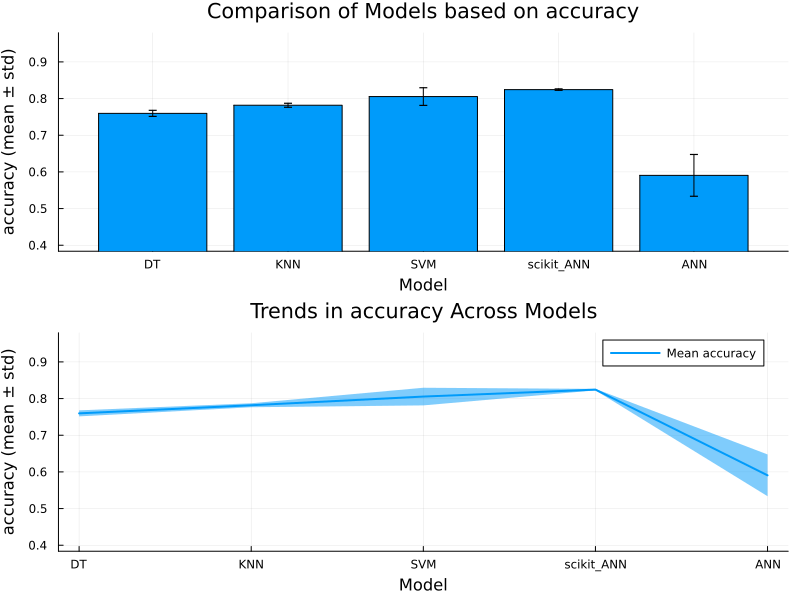

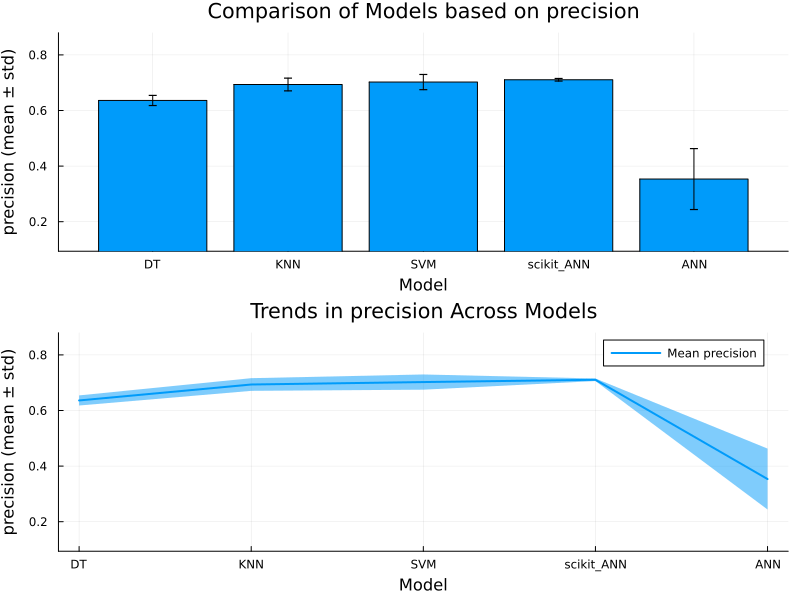

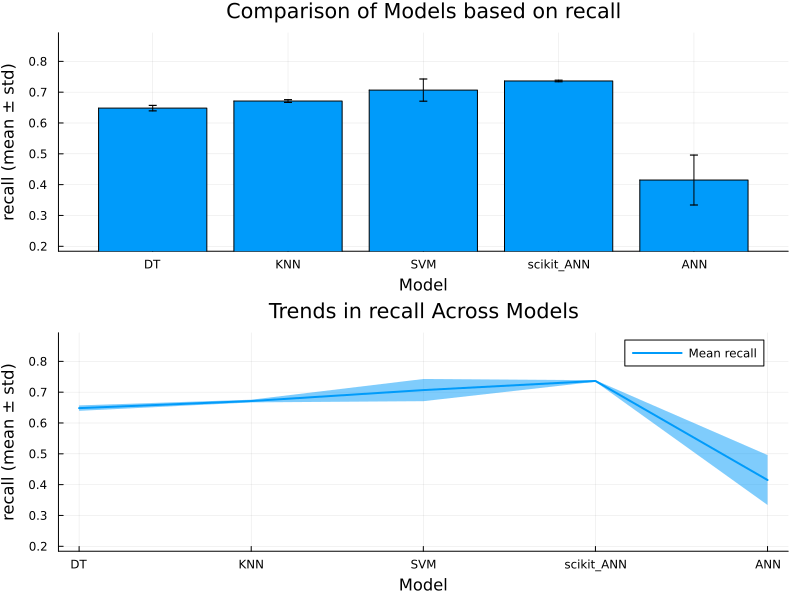

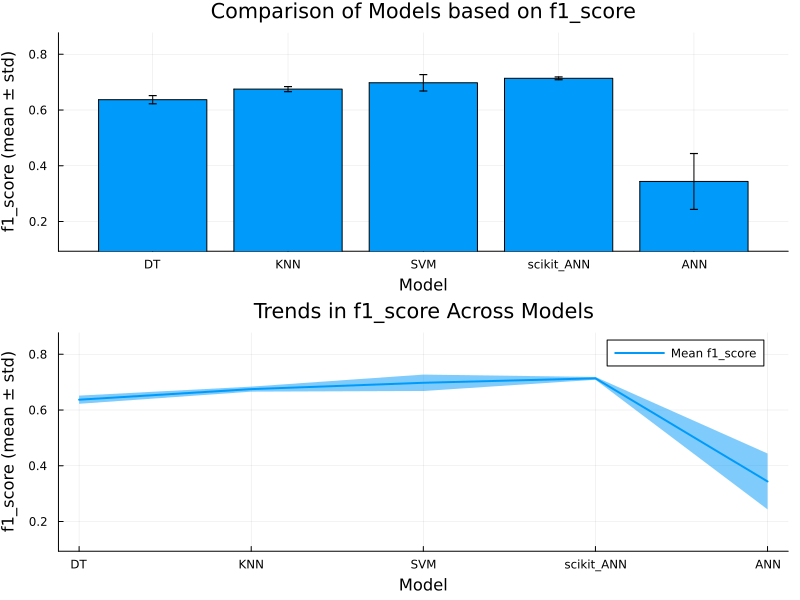

In [24]:
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir="./plots/Approach4/", show=true)

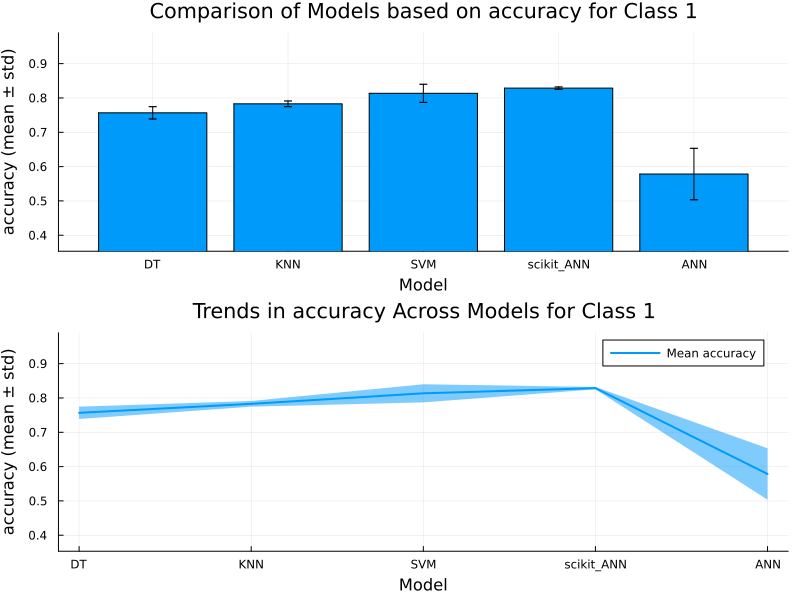

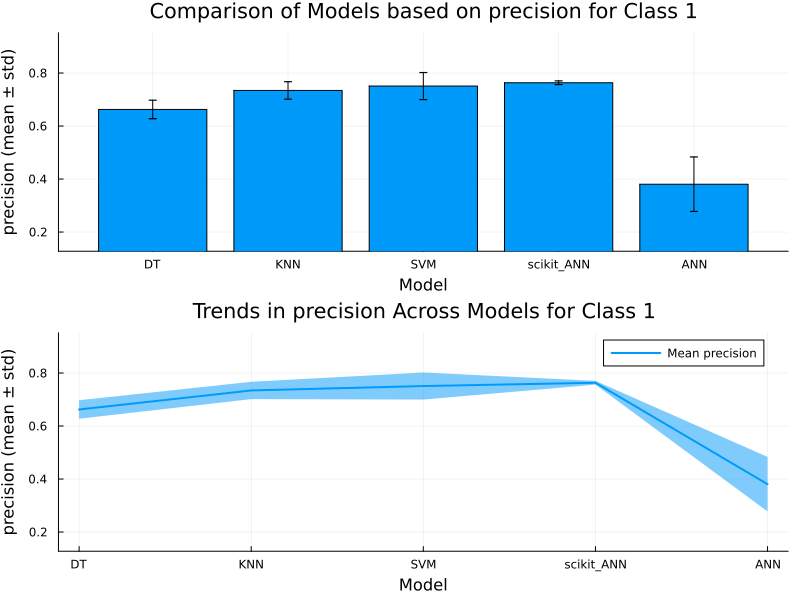

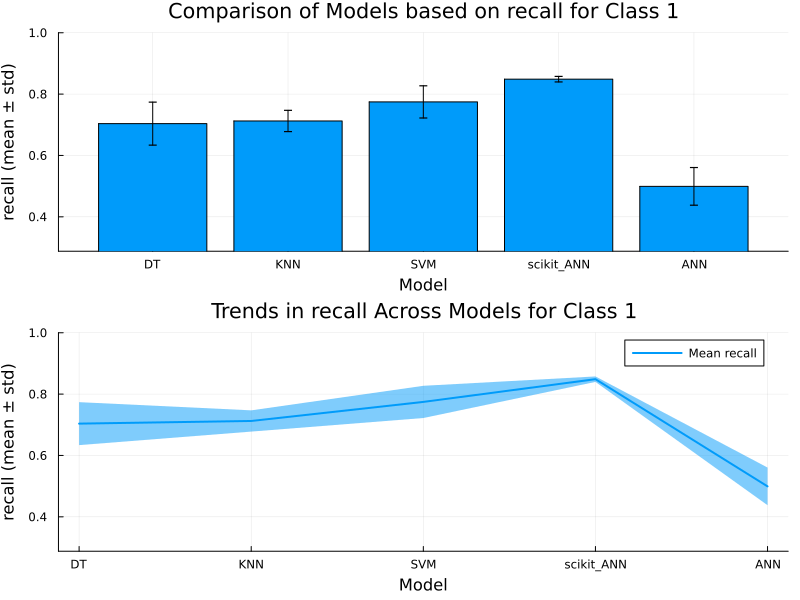

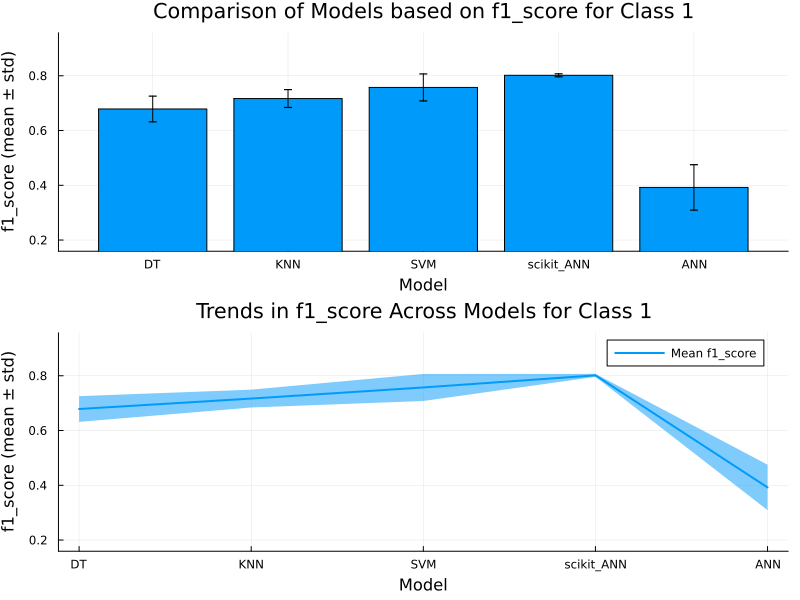

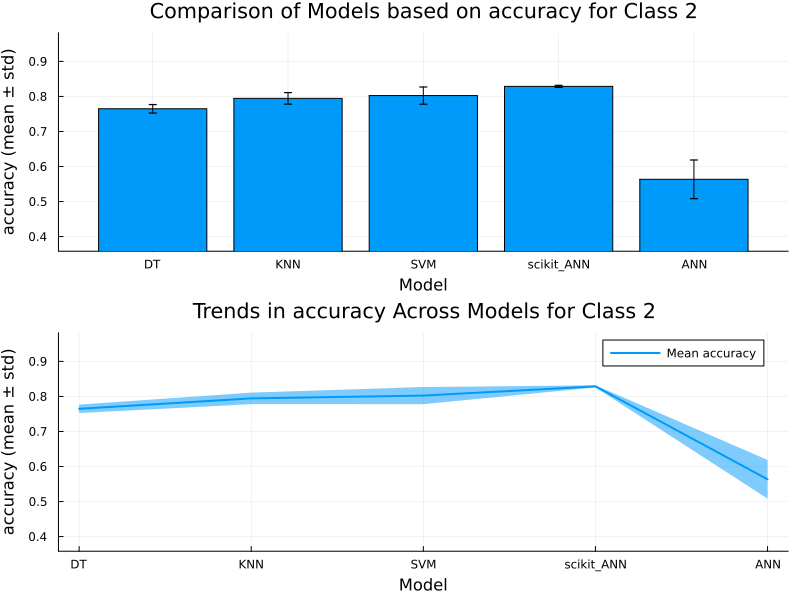

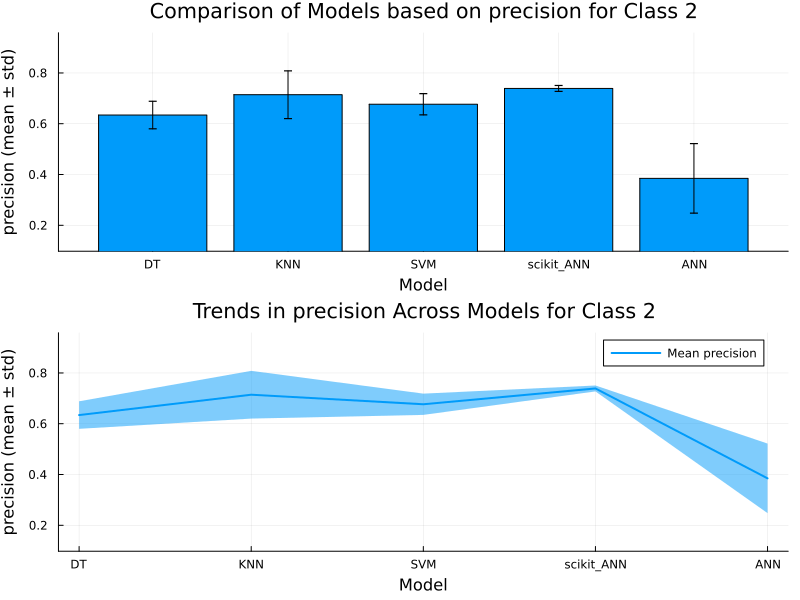

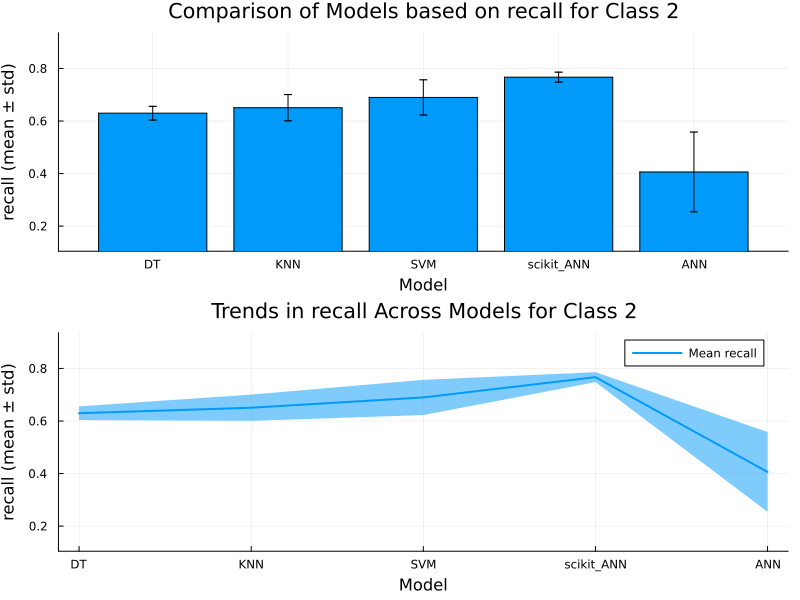

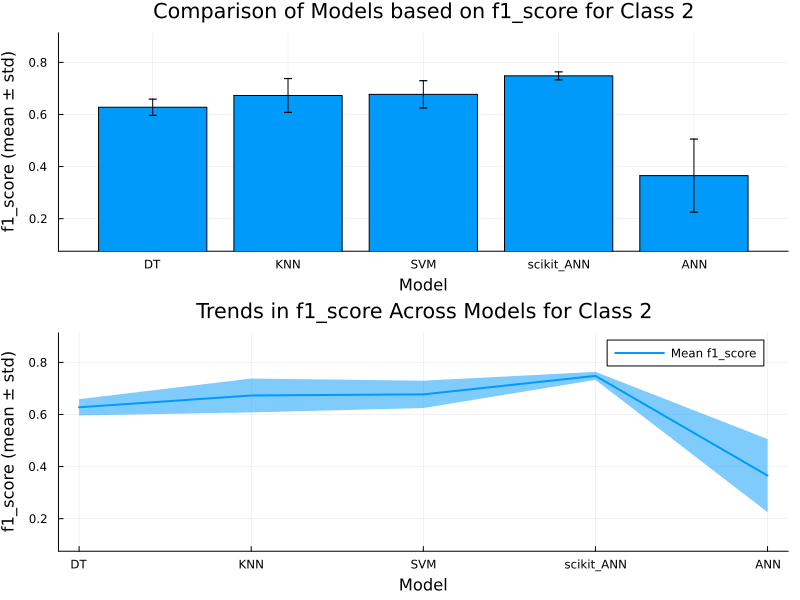

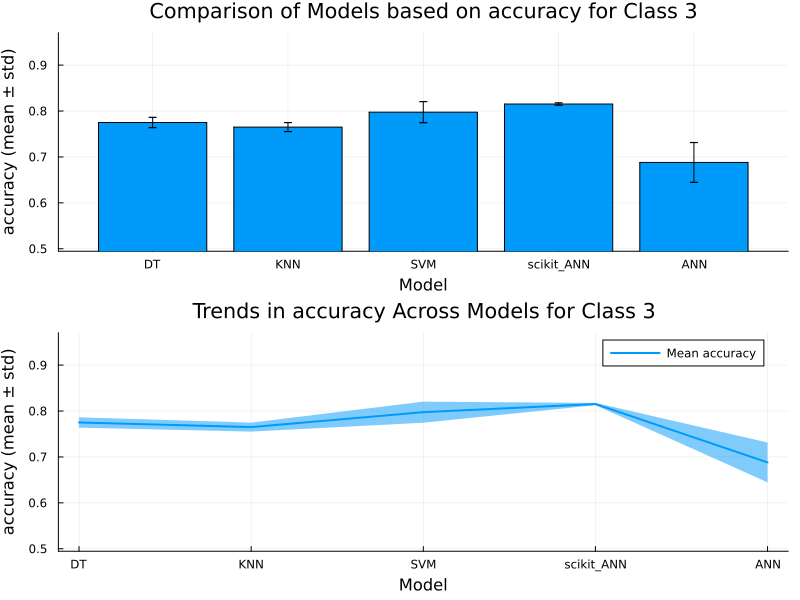

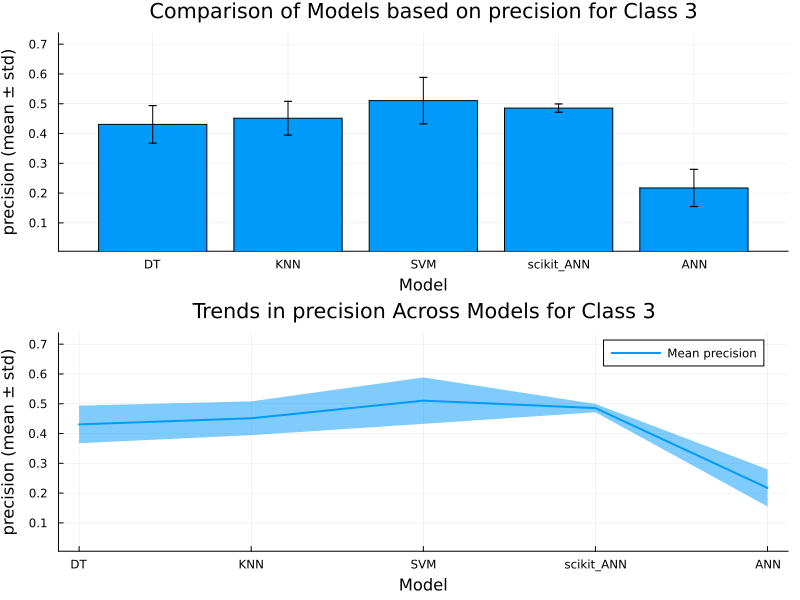

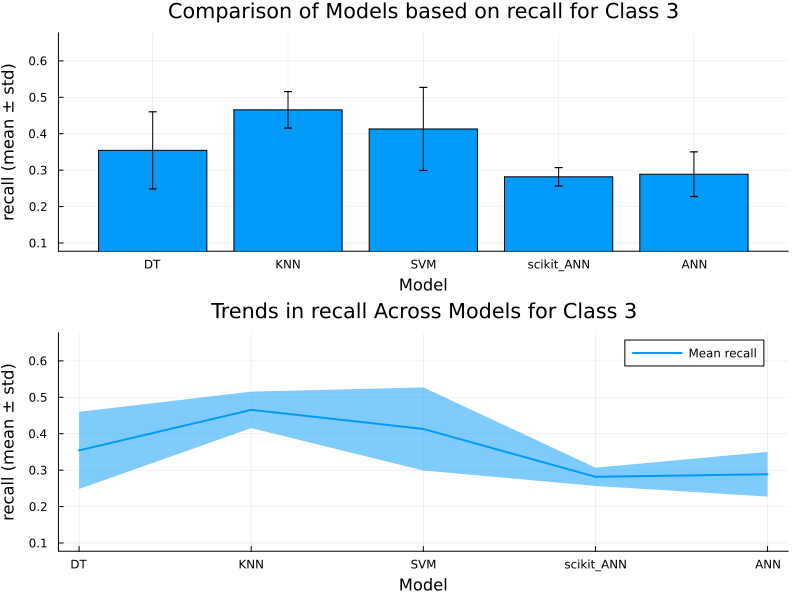

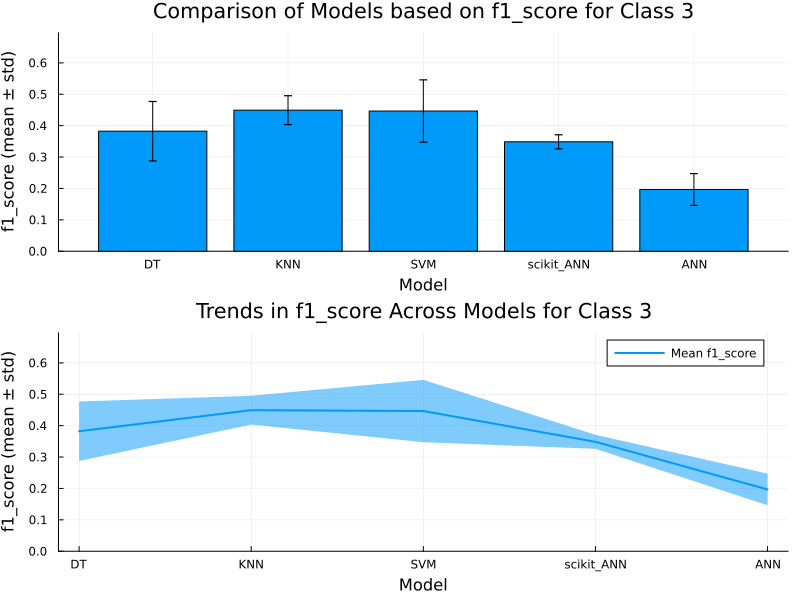

In [25]:
plotCombinedMetrics(model_names, 3, metrics, metric_means_class, metric_stds_class, output_dir="./plots/Approach4/Classes", show=true)

In [40]:
generateComparisonTable(model_names, metrics, metric_maxes; sort_by=:accuracy, rev=true)


Comparison of Maximum Metrics Across Models (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.845 │     0.747 │  0.766 │    0.744 │
│ scikit_ANN │    0.837 │     0.735 │  0.754 │    0.737 │
│        ANN │    0.818 │     0.712 │  0.726 │    0.717 │
│        KNN │    0.813 │     0.742 │  0.718 │    0.719 │
│         DT │    0.786 │     0.695 │  0.683 │     0.68 │
└────────────┴──────────┴───────────┴────────┴──────────┘


In [23]:
generateComparisonTable(model_names, 3, metrics, metric_maxes_class; output_dir="./tables/Approach4/Classes", sort_by=:accuracy, rev=true)


Comparison of Maximum Metrics Across Models for Class 1 (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.867 │     0.888 │  0.941 │    0.841 │
│ scikit_ANN │    0.861 │     0.802 │  0.926 │    0.845 │
│        ANN │    0.849 │     0.772 │  0.767 │    0.761 │
│        KNN │    0.833 │     0.898 │  0.862 │    0.812 │
│         DT │    0.819 │      0.83 │  0.914 │     0.79 │
└────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of Maximum Metrics Across Models for Class 2 (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.855 │     0.843 │   0.95 │    0.854 │
│ scikit_ANN │    0.849 │      0.79 │  0.894 │    0.822 │
│        KNN │    0.847 │     

## Ensemble models

After training the individual models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Naive Bayes**
- **Stacking** (using a logistic regression as the meta-model)


In [24]:
# Select the best models
estimators = [:ANN, :SVC, :KNN]
hyperparameters = Vector{Dict}([
  Dict(
    :hidden_layer_sizes => (64,64),
    :learning_rate_init => 0.01,
    :max_iter => 100,
    :early_stopping => true,
    :tol => 0,
    :validation_fraction => 0.15,
    :n_iter_no_change => 10,
    :epsilon => 0.0001
  ),
  Dict(
  :kernel => "rbf",
  :C => 1.0,
  :gamma => "auto",
  :probability => true,
  ),
  Dict(
    :n_neighbors => 9,
    :weights => "uniform",
    :metric => "euclidean",
  )])

# Define ensembles
ensembles = [
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
    )
  ),
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
      :voting => "soft",
      :weights => [0.5, 0.2, 0.3]
    )
  ),
  Dict(
    :type => :Stacking,
    :hyperparameters => Dict(
      :final_estimator => LogisticRegression()
    )
  )
]

3-element Vector{Dict{Symbol, Any}}:
 Dict(:type => :Voting, :hyperparameters => Dict{Any, Any}())
 Dict(:type => :Voting, :hyperparameters => Dict{Symbol, Any}(:voting => "soft", :weights => [0.5, 0.2, 0.3]))
 Dict(:type => :Stacking, :hyperparameters => Dict{Symbol, PyCall.PyObject}(:final_estimator => PyObject LogisticRegression()))

In [25]:
for (index, ensemble) in enumerate(ensembles)
    println("Training ensemble ", ensemble[:type])
    metrics, class_results = trainClassEnsemble(
        estimators,
        hyperparameters,
        (inputs, targets_label_encoded),
        fold_indices;
        ensembleType = ensemble[:type],
        ensembleHyperParameters = ensemble[:hyperparameters],
        metricsToSave = metrics_to_save,
        repetitionsTraining = 5,
        applyPCA = true,
        pcaComponents = 0.95,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
    )
    ensemble[:results] = metrics
    ensemble[:class_results] = class_results
    println("------------------------------------")
end

Training ensemble Voting
Mean accuracy: 0.83577 ± 0.01074
	Class 1: 0.83833 ± 0.01861
	Class 2: 0.83821 ± 0.02138
	Class 3: 0.83423 ± 0.02395
Mean precision: 0.73971 ± 0.02292
	Class 1: 0.78336 ± 0.02427
	Class 2: 0.74554 ± 0.04639
	Class 3: 0.59041 ± 0.14437
Mean recall: 0.75538 ± 0.01772
	Class 1: 0.874 ± 0.0923
	Class 2: 0.69101 ± 0.18287
	Class 3: 0.40007 ± 0.1779
Mean f1_score: 0.73587 ± 0.01737
	Class 1: 0.82217 ± 0.03209
	Class 2: 0.70208 ± 0.12376
	Class 3: 0.46939 ± 0.16654
------------------------------------
Training ensemble Voting
Mean accuracy: 0.83634 ± 0.00848
	Class 1: 0.83964 ± 0.01922
	Class 2: 0.83727 ± 0.0222
	Class 3: 0.83459 ± 0.02347
Mean precision: 0.74064 ± 0.01613
	Class 1: 0.78707 ± 0.0299
	Class 2: 0.73152 ± 0.08143
	Class 3: 0.59562 ± 0.14649
Mean recall: 0.75575 ± 0.01402
	Class 1: 0.86384 ± 0.08166
	Class 2: 0.67783 ± 0.20379
	Class 3: 0.42927 ± 0.17513
Mean f1_score: 0.73755 ± 0.01284
	Class 1: 0.81906 ± 0.02575
	Class 2: 0.68793 ± 0.1522
	Class 3: 0.49

In [26]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "4_ensemble_results.jl"

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :Voting_Hard => Dict(
    "general_results" => ensembles[1][:results],
    "class_results" => ensembles[1][:class_results]
  ),
  :Voting_Soft => Dict(
    "general_results" => ensembles[2][:results],
    "class_results" => ensembles[2][:class_results]
  ),
  :Stacking => Dict(
    "general_results" => ensembles[3][:results],
    "class_results" => ensembles[3][:class_results]
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

In [32]:
filename = results_folder * "4_ensemble_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end

model_names, metrics, metric_means, metric_stds, metric_means_class, metric_stds_class, metric_maxes, metric_maxes_class = aggregateMetrics(loaded_obj, 3, ensemble=true)

(Any["Voting_Hard", "Voting_Soft", "Stacking"], [:accuracy, :precision, :recall, :f1_score], Dict{Symbol, Vector{Any}}(:recall => [0.7553833852182288, 0.7557484457459852, 0.7652359938693396], :f1_score => [0.7358665854077305, 0.7375519460781168, 0.7527362658126275], :precision => [0.7397051528542757, 0.7406423883764595, 0.7517484788117482], :accuracy => [0.8357670041272692, 0.8363420322272548, 0.8444900313083206]), Dict{Symbol, Vector{Any}}(:recall => [0.017718510310382258, 0.014018348488477456, 0.012951153655129962], :f1_score => [0.017373153252385937, 0.01284232826332413, 0.011732225759361063], :precision => [0.0229222684681318, 0.0161271470749653, 0.014185351696641146], :accuracy => [0.010739101861645672, 0.008476958682198516, 0.00787824335883782]), Dict{Symbol, Vector{Any}}[Dict(:recall => [0.8740023954688413, 0.8638424597110707, 0.8467961832620372], :f1_score => [0.8221652788616705, 0.8190559170335636, 0.8246784966841911], :precision => [0.7833613222290335, 0.7870723723048625, 0.8

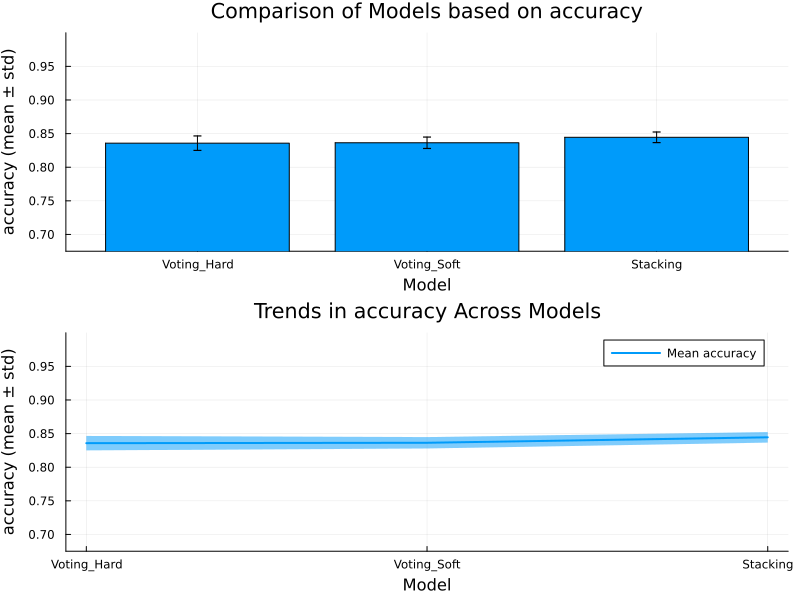

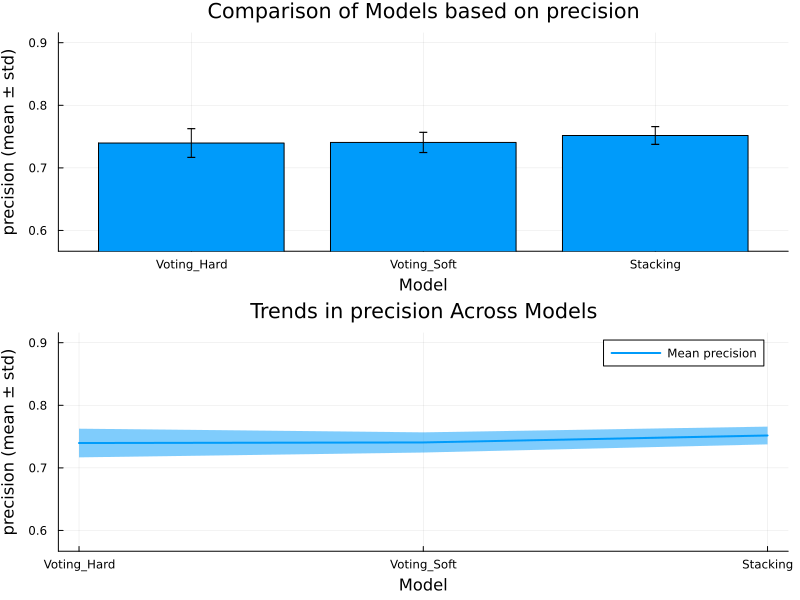

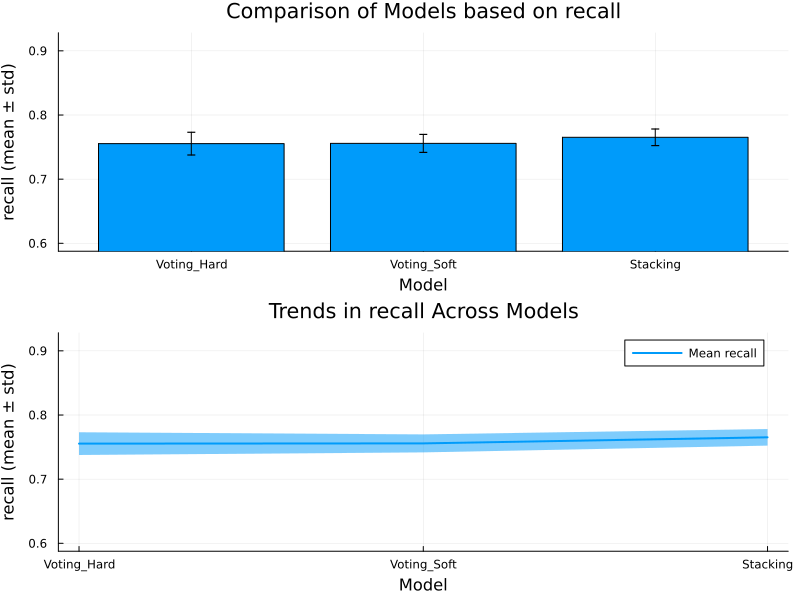

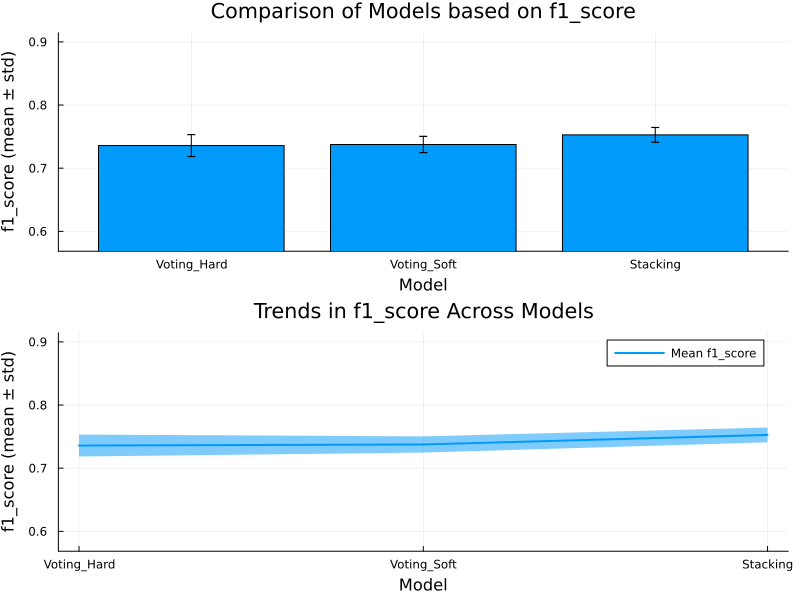

In [34]:
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir="./plots/Approach4/ensembles", show=true)

In [36]:
generateComparisonTable(model_names, metrics, metric_maxes; sort_by=:f1_score, rev=true)


Comparison of Maximum Metrics Across Models (Sorted by f1_score):
┌─────────────┬──────────┬───────────┬────────┬──────────┐
│       Model │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────┼──────────┼───────────┼────────┼──────────┤
│    Stacking │    0.853 │     0.772 │  0.782 │    0.768 │
│ Voting_Hard │    0.848 │     0.769 │  0.776 │    0.756 │
│ Voting_Soft │    0.845 │     0.754 │  0.769 │    0.749 │
└─────────────┴──────────┴───────────┴────────┴──────────┘


In [37]:
generateComparisonTable(model_names, 3, metrics, metric_maxes_class; sort_by=:f1_score, rev=true)


Comparison of Maximum Metrics Across Models for Class 1 (Sorted by f1_score):
┌─────────────┬──────────┬───────────┬────────┬──────────┐
│       Model │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────┼──────────┼───────────┼────────┼──────────┤
│    Stacking │    0.871 │     0.826 │   0.93 │    0.854 │
│ Voting_Hard │     0.86 │     0.813 │  0.952 │     0.85 │
│ Voting_Soft │     0.87 │     0.837 │  0.944 │    0.845 │
└─────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of Maximum Metrics Across Models for Class 2 (Sorted by f1_score):
┌─────────────┬──────────┬───────────┬────────┬──────────┐
│       Model │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────┼──────────┼───────────┼────────┼──────────┤
│    Stacking │    0.862 │     0.796 │  0.932 │    0.859 │
│ Voting_Soft │    0.869 │     0.828 │  0.914 │    0.826 │
│ Voting_Hard │    0.861 │     0.805 │   0.91 │    0.824 │
└─────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of M